# Parse NIDQ files for Feldman's Lab

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

import spikeextractors as se
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc
import spikewidgets as sw

%matplotlib notebook

14:51:29 [I] klustakwik KlustaKwik2 version 0.2.6


## 1) Load NIDQ data

In [ ]:
# base_path = Path("D:/Feldman")
# #base_path = Path("/Users/abuccino/Documents/Data/catalyst/brody/A256_bank1_2020_09_30_g0")
# #base_data_path = Path("D:/Neuropixels/Neuropixels/A256_bank1_2020_09_30/A256_bank1_2020_09_30_g0")
# base_data_path = Path("20210115_NPX_and_behavior/2021_01_15_E105/towersTask_g0")
# ap_bin_path = base_data_path / "towersTask_g0_imec0" / "towersTask_g0_t0.imec0.ap.bin"
# lf_bin_path = base_data_path / "towersTask_g0_imec0" / "towersTask_g0_t0.imec0.lf.bin"

In [7]:
base_path = Path("/Users/abuccino/Documents/Data/catalyst/feldman/")
session_name = "LR_210209_2_g1"
nidq_bin_path = base_path / session_name / f"{session_name}_t0.nidq.bin"

In [9]:
recording_nidq = se.SpikeGLXRecordingExtractor(nidq_bin_path)

### NIDQ signal description from Feldman

- AI0.  The synch signal from the imec card.  (This has not been present in every recording so far, but if you guys think this provides the most accurate synchronization method, we will use it routinely in every recording.)

- AI2.  Event message that encodes the trial number, the first stimulus number on that trial, and the segment number.
This is an analog signal (range: 0-4.5 V) that uses hexadecimal digit encoding.  One event message is sent for each trial, and it begins exactly at the trial start time.  Trial_number, stimulus_number and segment_number are sent, in that order, each encoded by 4 hex digits.  Each digit lasts 10 ms.  Digit order is MSD to LSD.  The digit value (0-15) is read as voltage*15/4.5. So for example, the decimal number 4098 is hex 0102 and is encoded by a 4-digit voltage sequence 0V, 0.3V, 0V, 0.6V, with each digit lasting 10 ms.   Within the event message, trial number is sent first (4 digits, 10 ms each) followed by stimulus number (4 digits, 10 ms each), followed by segment number (4 digits, 10 ms each).


- AI3.  Trial ongoing signal.  This is a 5V signal that begins at the onset of each behavioral trial, and turns off at the offset of each trial.

- AI4.  Trial start signal.  This is a TTL pulse, 200 microsecond duration, that marks the onset of each trial.  (This is duplicative with AI3 but is there for historical reasons.  There is no need to analyze this signal.)

- AI5.  Piezo monitor signal.  This is an analog voltage signal which is a copy of the voltage drive going to our whisker stimulation piezos.  We use the timing, amplitude, and shape of this signal to know the precise whisker stimulus that was delivered on each trial.

<IPython.core.display.Javascript object>


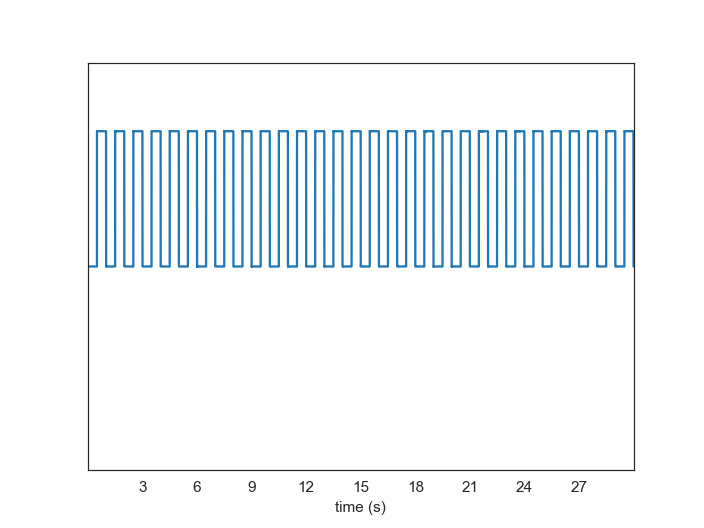

In [150]:
# AI0 - sync signal
_ = sw.plot_timeseries(recording_nidq, channel_ids=[0], trange=[0, 30])

**COMMENT**: Correctly corresponds to AI0 description: how can we use it to improve synchronization? This signal is generated by the imec board, but I cannot find where and if it is saved in the ap or lf stream.

<IPython.core.display.Javascript object>


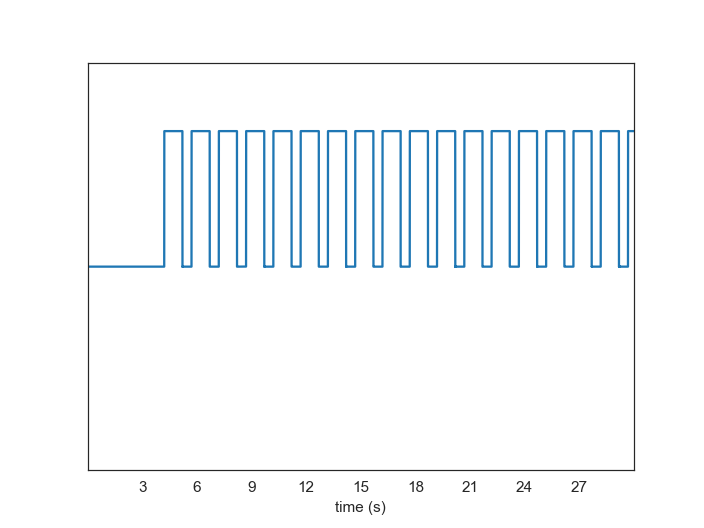

In [152]:
# AI3 - trial ongoing signal
_ = sw.plot_timeseries(recording_nidq, channel_ids=[3], trange=[0, 30])

**COMMENT**: Correctly corresponds to AI3 description: we have to use this signal to cut out individual trials

<IPython.core.display.Javascript object>


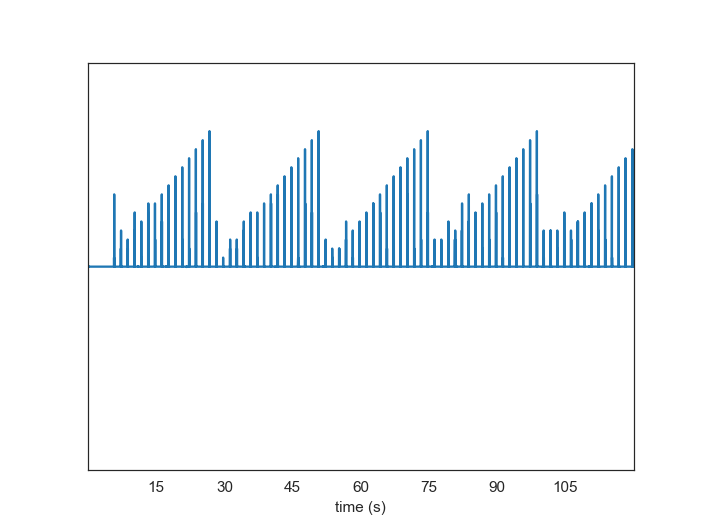

In [23]:
# AI4 - trial start signal
_ = sw.plot_timeseries(recording_nidq, channel_ids=[4], trange=[0, 30])

**COMMENT**: Corresponds to AI2 description, but it is instead AI4: we have to use this signal to parse trial number, stimulus number, and segment number for each trial 

<IPython.core.display.Javascript object>


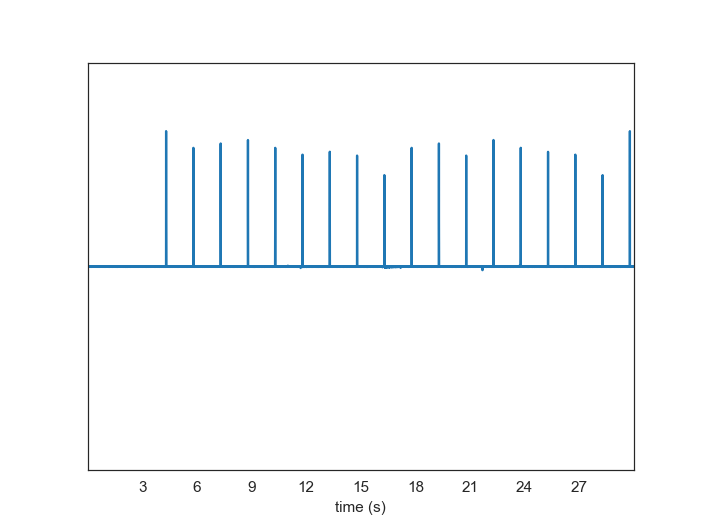

In [154]:
# AI5 - piezo motor signal
_ = sw.plot_timeseries(recording_nidq, channel_ids=[5], trange=[0, 30])

**COMMENT**: Corresponds to AI5 description, but it is instead AI4: we have to use this signal to parse trial number, stimulus number, and segment number for each trial 

<IPython.core.display.Javascript object>


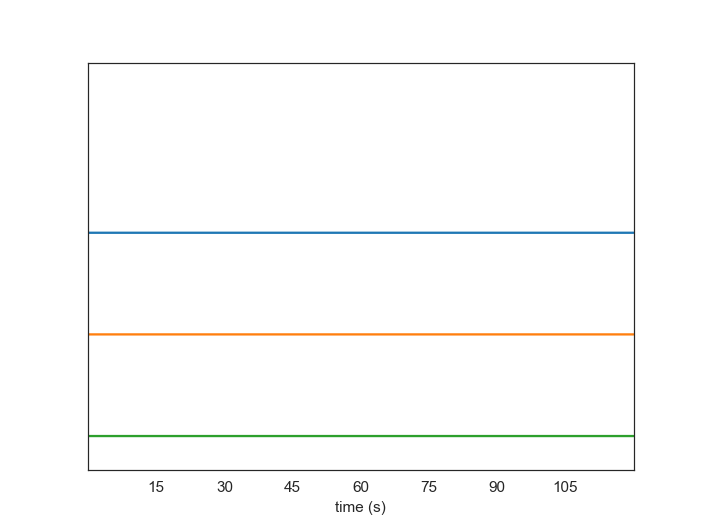

In [32]:
# AI 1-2-7 - not used
_ = sw.plot_timeseries(recording_nidq, channel_ids=[1, 2, 7], trange=[0, 120])

In [101]:
from tqdm import tqdm

In [164]:
def get_trials_info(recording_nidq, trial_ongoing_channel=3, event_channel=4):
    """
    This function parses trial number, stimulus number, and segment number for each trial. 
    First, the 'trial ongoing signal' is used to find start and stop index for each trial.
    Then, for each trial, the hex digits corresponding to trial number, stimulus number, 
    and segment number are extracted and converted to integer.
    
    Parameters
    ----------
    
    recording_nidq: se.SpikeGLXRecordingExtractor
        The NIDQ recording extractor
    trial_ongoing_channel: int
        The channel_id corresponding to the trial ongoing signal
    event_channel: int
        The channel id correponding to the event message signal
        
    Returns
    -------
    trial_numbers: list
        List with trial id for each trial
    stimulus_numbers: list
        List with stimulus id for each trial
    segment_numbers: list
        List with segment id for each trial
    trial_times: list
        List with t_start and t_stop for each trial
    """
    
    # define hex base and conversion
    hex_base = 16
    voltage_range = 4.5 * 1e6
    hex_dict = {0: "0", 1: "1", 2: "2", 3: "3", 
                4: "4", 5: "5", 6: "6", 7: "7", 
                8: "8", 9: "9", 10: "a", 11: "b",
                12: "c", 13: "d", 14: "e", 15: "f"}
    
    # get fs and define 10ms interval in samples (used to extract hex digits)
    nidq_fs = recording_nidq.get_sampling_frequency()
    tenms_interval = int(0.01 * nidq_fs)
    
    # get trial and event traces
    tr_trial = recording_nidq.get_traces(channel_ids=[trial_ongoing_channel])[0]
    tr_events = recording_nidq.get_traces(channel_ids=[event_channel])[0]
    
    # discretize trial ongoing signal
    tr_trial_bin = np.zeros(tr_trial.shape, dtype=int)
    tr_trial_bin[tr_trial > np.max(tr_trial) // 2] = 1
    
    # get trial start and trial stop indices
    t_start_idxs = np.where(np.diff(tr_trial_bin) > 0)[0]
    t_stop_idxs = np.where(np.diff(tr_trial_bin) < 0)[0]
    
    assert len(t_start_idxs) == len(t_stop_idxs), "Found a different number of trial start and trial stop indices"
    
    trial_numbers = []
    stimulus_numbers = []
    segment_numbers = []
    trial_times = []
    
    # Extract hex digits for each trial
    for t in tqdm(range(len(t_start_idxs)), desc="Parsing hex signals"):
        start_idx = t_start_idxs[t]
        stop_idx = t_stop_idxs[t]
        
        trial_times.append(recording_nidq.frame_to_time(np.array([start_idx, stop_idx])))
        
        i_start = start_idx
        trial_digits = ""
        stimulus_digits = ""
        segment_digits = ""

        # First 4 digits (10ms each) are the trial number
        for i in range(4):
            median_value = np.median(tr_events[i_start + 10:i_start + tenms_interval - 10])
            digit = int(np.round(median_value * (hex_base - 1) / voltage_range))
            trial_digits += hex_dict[digit]
            i_start += tenms_interval
        trial_numbers.append(int(trial_digits, hex_base))        
        
        # Second 4 digits (10ms each) are the stimulus number
        for i in range(4):
            median_value = np.median(tr_events[i_start + 10:i_start + tenms_interval - 10])
            digit = int(np.round(median_value * (hex_base - 1) / voltage_range))
            stimulus_digits += hex_dict[digit]
            i_start += tenms_interval
        stimulus_numbers.append(int(stimulus_digits, hex_base))        
        
        # Third 4 digits (10ms each) are the segment number
        for i in range(4):
            median_value = np.median(tr_events[i_start + 10:i_start + tenms_interval - 10])
            digit = int(np.round(median_value * (hex_base - 1) / voltage_range))
            segment_digits += hex_dict[digit]
            i_start += tenms_interval
        segment_numbers.append(int(segment_digits, hex_base))        
    
    return trial_numbers, stimulus_numbers, segment_numbers, trial_times

In [165]:
trial_numbers, stimulus_numbers, segment_numbers, trial_times = get_trials_info(recording_nidq, 
                                                                                trial_ongoing_channel=3, 
                                                                                event_channel=4)

Parsing hex signals: 100%|██████████| 1080/1080 [00:00<00:00, 1481.33it/s]


In [166]:
trial_times

[array([4.190614, 5.190448]),
 array([5.690645, 6.690479]),
 array([7.190636, 8.19047 ]),
 array([8.690667, 9.690501]),
 array([10.190698, 11.190532]),
 array([11.690689, 12.690522]),
 array([13.190719, 14.190553]),
 array([14.69075 , 15.690584]),
 array([16.190781, 17.190575]),
 array([17.690772, 18.690606]),
 array([19.190803, 20.190637]),
 array([20.690834, 21.690667]),
 array([22.190824, 23.190658]),
 array([23.690855, 24.690689]),
 array([25.190886, 26.19072 ]),
 array([26.690877, 27.690711]),
 array([28.190908, 29.190742]),
 array([29.690939, 30.690773]),
 array([31.190929, 32.190763]),
 array([32.69096 , 33.690794]),
 array([34.190991, 35.190825]),
 array([35.690982, 36.690816]),
 array([37.191013, 38.190847]),
 array([38.691044, 39.690878]),
 array([40.191074, 41.190868]),
 array([41.691065, 42.690899]),
 array([43.191096, 44.19093 ]),
 array([44.691127, 45.690961]),
 array([46.191118, 47.190952]),
 array([47.691149, 48.690983]),
 array([49.19118 , 50.191013]),
 array([50.69121

Now we just need to write this info to NWB!